# Gan

This notebook covers the process of building a Generative Adversarial Network (GAN) and it's application to the `MNIST` dataset.

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision.transforms as T
import torchvision.utils as vutils
from torchvision.datasets import MNIST

from pathlib import Path
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")
print("using device", DEVICE)

using device cpu


As example `MNIST` dataset will be used.

In [2]:
train_dataset = MNIST(
    Path("mnist_files"),
    download=True,
    train=True,
    transform=T.ToTensor()
)

In [9]:
# Generator's feature map
ngf = 64
# Input channels
nc = 1
# Size of the vector from which generator will create a picture
nz = 100

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # (nz) x 1 x 1
            nn.ConvTranspose2d(
                in_channels=nz, 
                out_channels=ngf * 2, 
                kernel_size=7,
                stride=1, 
                padding=0, 
                bias=False
            ),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            # (ngf*2) x 7 x 7
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            # (ngf) x 14 x 14
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh(),
            # (nc) x 28 x 28
        )

    def forward(self, input):
        return self.main(input)

# Discriminator's feature map
ndf = 64

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # (nc) x 28 x 28
            nn.Conv2d(
                in_channels=nc, 
                out_channels=ndf, 
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True),


            # (ndf) x 14 x 14
            nn.Conv2d(
                in_channels=ndf, 
                out_channels=ndf * 2, 
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False
            ),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),


            # (ndf*2) x 7 x 7
            nn.Conv2d(
                in_channels=ndf * 2, 
                out_channels=1, 
                kernel_size=7, 
                stride=1, 
                padding=0, 
                bias=False
            ),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [10]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

netG = Generator().to(DEVICE)
netG = netG.apply(weights_init)

netD = Discriminator().to(DEVICE)
netD = netD.apply(weights_init)

In [11]:
criterion = nn.BCELoss()

lr = 0.001
beta1 = 0.5

# We'll draw images from the same input to compare results.
fixed_noise = torch.randn(64, nz, 1, 1, device=DEVICE)

# Labels for real and fake images
real_label, fake_label = 1., 0.

optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
img_list = []
G_losses = []
D_losses = []
iters = 0

num_epochs = 10
dataloader = DataLoader(train_dataset)

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        real_batch = data[0].to(DEVICE)
        batch_size = real_batch.size(0)
        

        # Maximazing over discriminator log(D(x)) + log(1 - D(G(z)))
        # Step on the real image
        netD.zero_grad()
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=DEVICE)
        output = netD(real_batch).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Step on the fake image
        noise = torch.randn(batch_size, nz, 1, 1, device=DEVICE)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # Maximizing for generator log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 50 == 0:
            print(
                "[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f"
                % (
                    epoch,
                    num_epochs,
                    i,
                    len(dataloader),
                    errD.item(),
                    errG.item(),
                    D_x,
                    D_G_z1,
                    D_G_z2,
                )
            )
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        if (iters % 500 == 0) or (
            (epoch == num_epochs - 1) and (i == len(dataloader) - 1)
        ):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        iters += 1

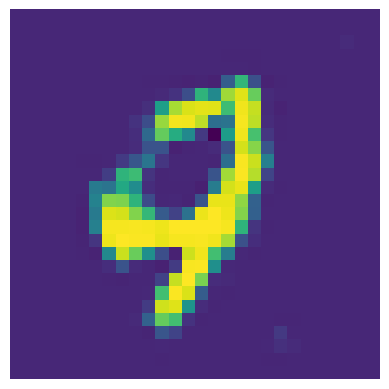

In [50]:
noize = torch.randn(batch_size, nz, 1, 1, device=DEVICE)
plt.imshow(netG(noize).squeeze().detach().numpy())
plt.axis(False)
plt.show()